## Acoustic Signal Processing for Bioacoustics
### 08 - Sound source localization

In this notebook, we introduce the concepts of sound source localization using farfield and nearfield acoustic propagation.

Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sounddevice as sd
import soundfile as sf
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl



### Introduction

As we have seen in the Spatial Filtering notebook, because source signals arrive at different times to multiple microphones, this information can be used to estimate the location of a source. There are a plethora of methods in the literature for sound source localization algorithms, but here we outline three fundamental concepts upon which many of these sound source localization algorithms are based:

1. Cross-correlation - A mathematical function which allows us to estimate the time delay between microphone signals.
2. Direction of Arrival (DOA) Localization - The time delay between microphones is based on the assumption of far-field propagation of the source signal, which is used to estimate the angle (DOA) of the source in relation to the microphone array. 
3. Hyberbolic localization - The time delay between microphones is based on the assumption of near field propagation and estimates the actual position coordinates of the source.



### Cross-correlation

The cross-correlation essentially measures the similarity between two signals, $x(t)$ and $y(t)$ and is used to estimate the time delay between the two signals. The cross-correlation is defined as:

\begin{equation}
r_{xy}(\tau) = \frac{1}{T}\int_{0}^{T} x(t)y(t+\tau) dt
\end{equation}

In this equation $\tau$ is what is referred to as a 'lag' and represents a time-shift of the signal, $y(t)$. So the cross-correlation, $r_{xy}(\tau)$ is a measure of the correlation between the time-shifted version of $y(t)$ at lag $\tau$ and $x(t)$. We can imagine this process as sliding shifted versions of $y(t)$ over $x(t)$ and computing the integral. Hence the value of $\tau$ for which the cross-correlation is a maximum corresponds to the time-delay between $x(t)$ and $y(t)$. 

This becomes a bit easier to visualise and think about when we consider discrete-time signals. For a zero-mean discrete-time signals, both of length N, $x[n]$ and $y[n]$, sampled at sampling frequency $f_{s}$ Hz, the sample cross-correlation, $r_{xy}[k]$ is similarly defined as follows:

\begin{equation}
r_{xy}[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n]y[n+k]
\end{equation}

where $N = T*dt = T/f_s$ and $k$ is the lag (time delay in discrete samples). Whereas $\tau$ in the continuous-time case could take any value of time, in the discrete-time case, the lags, $k$ are constrained to integer multiples of $1/f_s$. 

In practice therefore, when we capture signals using multiple microphones, we can perform a cross-correlation between pairs of signals to estimate the time delays between microphones, which are essential for doing source localization. The accuracy of the time delay estimation, however, depends on several factors - signal to noise ratio, the type of signals measured, reverberance, etc. 



In [2]:
# In order to compute the cross-correlation, we need to zero-pad the signal y[n] 
# with N zeros before the start of the signal and N zeros after. We will then create a copy of this
# signal and shift it accordingly by the lags to obtain rxy[k]
# We will build a function to do this so we can analyse other signals later. 
# We assume that x and y have the same length, N

# Note - my function here is not very efficient, but the point is to explicitly show how the cross-correlation is done. For faster methods look
# into the scipy function correlate - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

def crosscorr(x,y):

    N = len(x)
    
    # Zero-padding signals
    y_zp_shift = np.zeros([3*N]) 
    x_zp = np.zeros([3*N]) 
    x_zp[N:2*N] = x # zero padded x signal
    y_zp_shift[0:N] = y # copy of the above signal which we will shift accordingly
    
    rxy = np.zeros([2*N]) 
    lags = np.zeros([2*N])
    
    
    # Computing the autocorrelation
    for k in np.arange(0,2*N,1):
        y_shifted = np.roll(y_zp_shift,k)
        rxy[k] = (x_zp.T@y_shifted)
        lags[k] = k-N # we need to offset the shift index by N to get the true lag value. 
                      # This is just because we essentially offset the y[k] by N samples and zero padded on either side to do the cross-correlation 

    return lags, rxy

Listen to x:


Listen to y:


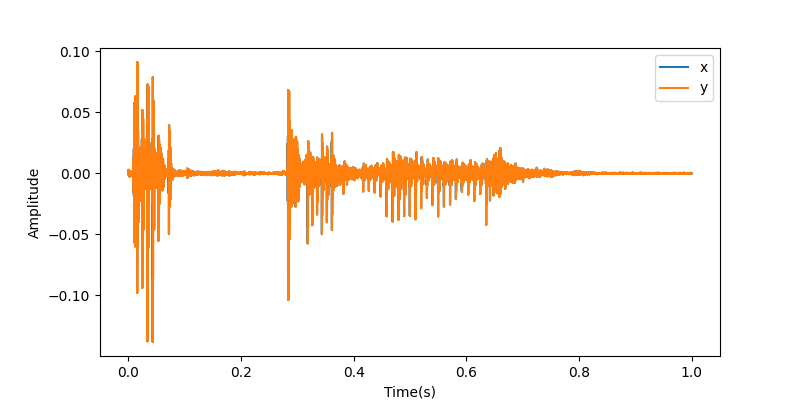

In [3]:
# Let's apply this to some real signals and see how well we can compute the time delay
# Read in the signal
[x_raw,fs] = sf.read('./audio/Wes_cap_stereo.wav') # Read in your audio file
x = x_raw[:,0] 
y = x_raw[:,1] 
x = x - np.mean(x) # Removing the mean of the signal
N = len(x)
# del x_raw

tt = np.arange(0,N/fs,1/fs)

# Let's first plot the signals
fig, axes = plt.subplots(figsize=(8, 4)) 
fig.subplots_adjust(hspace=0.5)
axes.plot(tt,x,label='x')
axes.plot(tt,y,label='y')
axes.set_xlabel('Time(s)')
axes.set_ylabel('Amplitude')
axes.legend()

print('Listen to x:')
IPython.display.display(Audio(x.T, rate=fs))
print('Listen to y:')
IPython.display.display(Audio(y.T, rate=fs))

Move the slider to see the computation for different values of k:


interactive(children=(IntSlider(value=0, description='k_off', max=32000), Output()), _dom_classes=('widget-int…

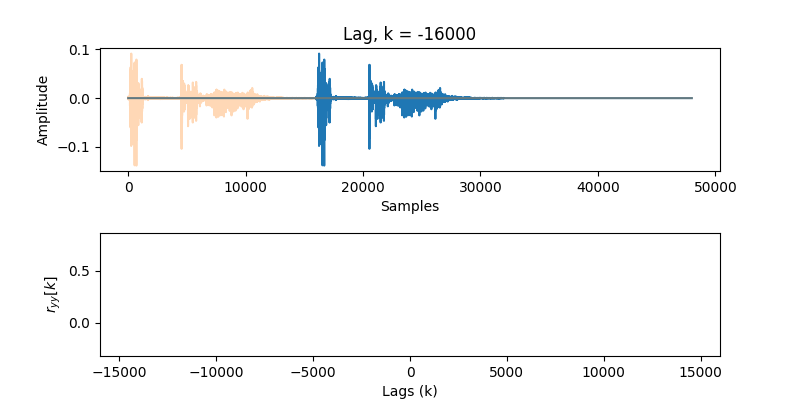

In [4]:
# Estimating the time delay with the cross-correlation

# Apply the crosscorr function:
lags, rxy = crosscorr(x,y)



# Repeating the creation of these variables just for the purpose of plotting:
x_zp = np.zeros([3*N]) 
x_zp_shift = np.zeros([3*N]) 
x_zp[N:2*N] = x # zero padded original signal
x_zp_shift[0:N] = x # copy of the above signal which we will shift accordingly


y_zp = np.zeros([3*N]) 
y_zp_shift = np.zeros([3*N]) 
y_zp[N:2*N] = y # zero padded original signal
y_zp_shift[0:N] = y # copy of the above signal which we will shift accordingly


# Do the interactive plot 
fig, axes = plt.subplots(2,1,figsize=(8, 4)) 
fig.subplots_adjust(hspace=0.5)
axes[0].plot(x_zp)
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot([], [])
axes[1].set_xlabel('Lags (k)')
axes[1].set_ylabel('$r_{yy}[k]$')
axes[1].set_xlim([lags[0], lags[-1]])
axes[1].set_ylim([np.min(rxy), np.max(rxy)])

line, = axes[0].plot(y_zp_shift,alpha=0.3)
line2, = axes[1].plot([],[],'g-')

def update(k_off = 0):
    
    y_shifted = np.roll(y_zp_shift,k_off)
    line.set_ydata(y_shifted)
    axes[0].set_title('Lag, k = ' + str(k_off-N))
    
    line2.set_data(lags[0:k_off],rxy[0:k_off])

print('Move the slider to see the computation for different values of k:')
interact(update, k_off = (0,2*N,1));


In [5]:
# Estimating the time delay:

index_max = np.argmax(rxy)     # get index corresponding to make value of rxy
sample_delay = lags[index_max] # the lag value at this index is the sample delay
time_delay = np.abs(sample_delay)/fs # conver the ssample to time
print('Sample delay between 2 signals:', sample_delay, 'samples')
print('Corresponding time delay estimate between 2 signals:', time_delay, 'seconds')


Sample delay between 2 signals: -4.0 samples
Corresponding time delay estimate between 2 signals: 0.00025 seconds


### Direction of Arrival (DOA)

Recall from the Spatial filtering notebook, we saw that upon assuming far field acoustic propagation, we can relate the time delays between microphones to a direction or arrival (DOA) impinging from some angle, $\theta$ as shown in Fig. 1.

<br>
<br>

<div>
<center> <img src="img/ULA.png" width="350"/> <center/>
    <p style="text-align:center">Fig. 1 - Uniformly spaced linear microphone array with a target source in the far field. </p>
</div>

<br>
<br>


For linear array with microphones space $d$ metres apart, it can be observed that the additional distance that the plane waves travel to each successive microphone is simply a factor of $d \cos \theta$. Hence we recall that the time delay, $\tau_{m}$ associated with the $m^{th}$ microphone for $m \in [2, 3, \dots, \mathrm{M}]$ can be parametrized as a function of the angle $\theta$ as follows:

\begin{equation}
\tau_{m}(\theta) = \frac{(m-1) d \cos \theta}{c}
\end{equation}

And hence, if there is an estimate for $\tau_{m}$ (say from the cross-correlation for instance), we can compute the DOA by solving the equation (for $m \in [2, 3, \dots, \mathrm{M}]$):
\begin{equation}
 \theta = \cos^{-1} \left( \frac{c \tau_{m}}{(m-1) d } \right)
\end{equation}

So in the case of a pair of microphones for instace, the DOA will simply be estimated as
\begin{equation}
 \theta = \cos^{-1} \left( \frac{c \tau_{2}}{d } \right)
\end{equation}
where $\tau_{2}$ is the time delay between the two microphones.

With two microphones, however, a DOA estimate is ambiguous. In the following interactive plot, the time delay corresponds to 2 possible DOAs in 2-D, however in 3-D, it corresponds to a cone along which the source can lie, i.e., there are many more directions from which the source could have arrived. Hence in practice, more than two microphones are needed (which do not lie in a line) to resolve the ambiguity. Specifically for 2-D, at least three microphones are needed and for 3-D, at least four microphones are needed (unique intersection of cones resolves the ambiguity).

Move 1st slider to change the DOA, 2nd slider to turn off/on the cone visual:


interactive(children=(FloatSlider(value=20.0, description='DOA (deg.)', max=60.0, min=5.0, step=1.0), IntSlide…

<function __main__.plot_cone(DOA=20, transparency=0)>

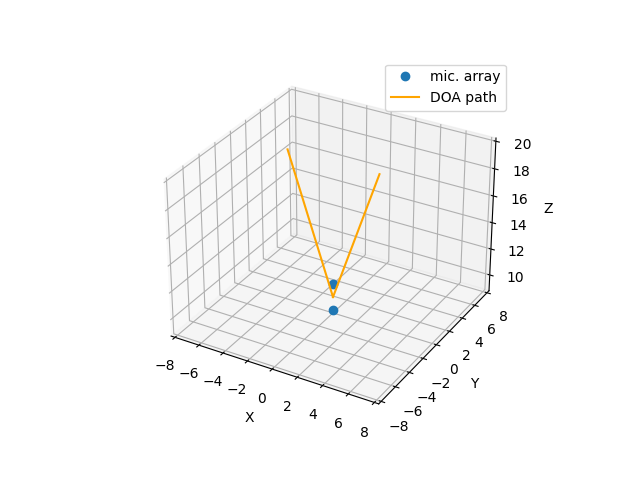

In [6]:
### Visualization of the direction of arrival in 3D

# Parameters for the cone
height = 10   # Height of the cone (making negative as I want to visualize the apex from the bottom going up)
DOA = 20      # direction of arrival (degrees)
num_edges = 101   # Number of radial edges to plot

# Coordinates of the apex (tip of the cone)
apex = np.array([0, 0, height])

# Angles for the edges on the base circle
angles = np.linspace(0, 2 * np.pi, num_edges)
base_z = np.ones(num_edges)

# Setting up figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


def plot_cone(DOA=20, transparency=0):
    
    ax.clear()
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    # ax.set_zlim([-15, 0])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.plot([0,0],[0,0],[11,9], 'o', label='mic. array')
    

    DOA_rad = (np.pi/180)*DOA                # direction of arrival (radians)
    radius = np.abs(height)*np.tan(DOA_rad)  # Radius of the cone's base

    # Coordinates of the base circle
    base_x = radius * np.cos(angles)
    base_y = radius * np.sin(angles)

    ax.plot([apex[0], base_x[0]], [apex[1], base_y[0]], [apex[2], 2*height*base_z[0]], color='orange',label='DOA path')
    ax.plot([apex[0], base_x[50]], [apex[1], base_y[50]], [apex[2], 2*height*base_z[0]], color='orange')
    
    for i in range(num_edges):
        ax.plot([apex[0], base_x[i]], [apex[1], base_y[i]], [apex[2], 2*height*base_z[i]], color='orange', alpha= transparency)

    # circular base
    ax.plot(base_x, base_y, 2*height*base_z, color='red', linestyle='solid', linewidth=2, alpha=transparency)
    
    ax.legend(loc='upper right')
 
print('Move 1st slider to change the DOA, 2nd slider to turn off/on the cone visual:')
interact(plot_cone, DOA=widgets.FloatSlider(value=20, min=5, max=60, step=1, description='DOA (deg.)'))



### Hyperbolic localization

In comparison with DOA approaches, we can impose a nearfield propagation model for time difference of arrivals (TDOAs) between microphones. Therefore, instead of estimating the angle from which a source signal impinges the array, we can directly estimate the source coordinates. 

Consider a 2-D scenario with two microphones and let us define the following:
1. Source location, $\mathbf{r}_{s}$ = $[x_s, y_s]$
2. Mic. 1 location, $\mathbf{r}_{1}$ = $[x_{1}, y_{1}]$ 
3. Mic. 2 location, $\mathbf{r}_{2}$ = $[x_{2}, y_{2}]$
4. Distance from the source to mic. 1: $\|\mathbf{r}_{s} - \mathbf{r}_{1}  \|_{2} = \sqrt{ (x_s - x_1)^{2} + (y_s - y_1)^{2} } $
5. Distance from the source to mic. 2: $\|\mathbf{r}_{s} - \mathbf{r}_{2}  \|_{2} = \sqrt{ (x_s - x_2)^{2} + (y_s - y_2)^{2} } $

(Note that the notation $\|.\|$ deontes the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). 

The TDOA, $\tau$, between the microphones is defined as the difference in the time of arrivals from the source to each microphone:

\begin{equation}
\tau =  \frac{\Delta d}{c} = \frac{\sqrt{ (x_s - x_1)^{2} + (y_s - y_1)^{2} } }{c} -  \frac{\sqrt{ (x_s - x_2)^{2} + (y_s - y_2)^{2} } }{c}
\end{equation}

where $c$ is the speed of sound (m/s) and $\Delta d$ is the difference in distance travelled from one microphone to another. Since $c$ is common to all equations, we can simply re-write this as:

\begin{equation}
\Delta d = \sqrt{ (x_s - x_1)^{2} + (y_s - y_1)^{2}}  -  \sqrt{ (x_s - x_2)^{2} + (y_s - y_2)^{2} }
\end{equation}

As seen in the interactice plot below, this equation corresponds to the source being constrained to a hyperbola in 2-D and a hyperboloid in 3-D. Hence, as with the DOA, the source location is not unique and more microphones (at least 4 in 2-D and at least 5 in 3-D) are needed to find unique intersections between hyperbolas/hyperboloids in order to obtain estimates for unique source positions. 

In the following interactive plots, we visualize this. In the final plot, we show how difficult the problem becomes when considering multiple sources in the scenario. 


Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)


interactive(children=(IntSlider(value=15, description='xs', max=20, min=-20), IntSlider(value=10, description=…

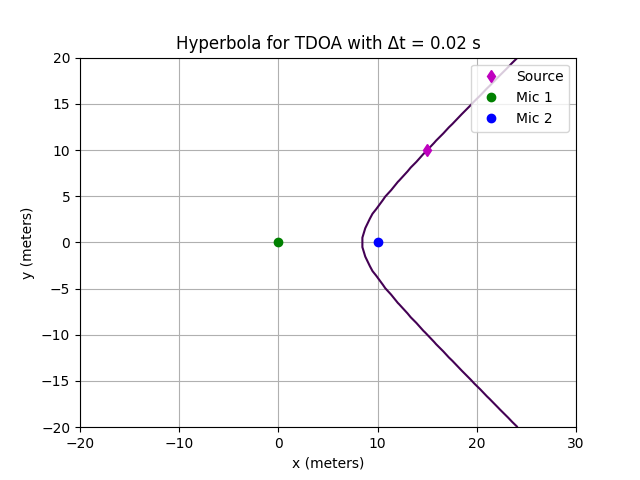

In [7]:
# 2-D interactive plot

# source location
S = np.array([15, 10]) # source position

# Mic positions
M1 = np.array([0, 0]) 
M2 = np.array([10, 0]) 

# Speed of sound/signal (e.g., speed of sound in air ≈ 343 m/s)
c = 343  # meters per second

# Time difference of arrival in seconds
toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2

t_doa = toa_mic1-toa_mic2  # time difference of arrival

# Calculate the distance difference based on the tdoa
d = c * t_doa  # distance difference

# Generate a grid of points
x = np.linspace(-20, 30, 40)
y = np.linspace(-20, 20, 40)
X, Y = np.meshgrid(x, y)

# Calculate the distances to the two mics for each point (X, Y)
D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)

# Calculate the difference in distances
distance_diff = D1 - D2 # this is essentially equal d above

Z_hyp = (d - distance_diff) # this value should be close to zero and is the contour line (hyperbola) we want to plot.

# # Plot the hyperbola where the distance difference is equal to the calculated d

fig, ax = plt.subplots()

ax.set_xlim([-20, 30])
ax.set_ylim([-20, 20])

def update(xs = 15, ys = 10):
    ax.clear()
    
    S = np.array([xs, ys]) # source position

    # Time difference of arrival in seconds
    toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
    toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2
    
    t_doa = toa_mic1-toa_mic2  # time difference of arrival
    
    # Calculate the distance difference based on the tdoa
    d = c * t_doa  # distance difference

    # Calculate the distances to the two mics for each point (X, Y)
    D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
    D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)
    
    # Calculate the difference in distances
    distance_diff = D1 - D2 # this is essentially equal d above
    
    Z_hyp = (d - distance_diff) # this value should be close to zero and is the contour line (hyperbola) we want to plot.
    
    cmap = ax.contour(X, Y, Z_hyp, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot


    # Update plot parameters
    
    ax.plot(xs, ys, 'md', label="Source")
    ax.set_title(f'Hyperbola for TDOA with Δt = {np.round(t_doa,decimals=4)} s')
    ax.plot(M1[0], M1[1], 'go', label="Mic 1")
    ax.plot(M2[0], M2[1], 'bo', label="Mic 2")
    ax.set_xlabel('x (meters)')
    ax.set_ylabel('y (meters)')
    ax.legend()
    ax.grid(True)

print('Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)')
interact(update, xs = (-20,20,1), ys = (-20,20,1)); 


Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)


interactive(children=(IntSlider(value=15, description='xs', max=30, min=-20), IntSlider(value=10, description=…

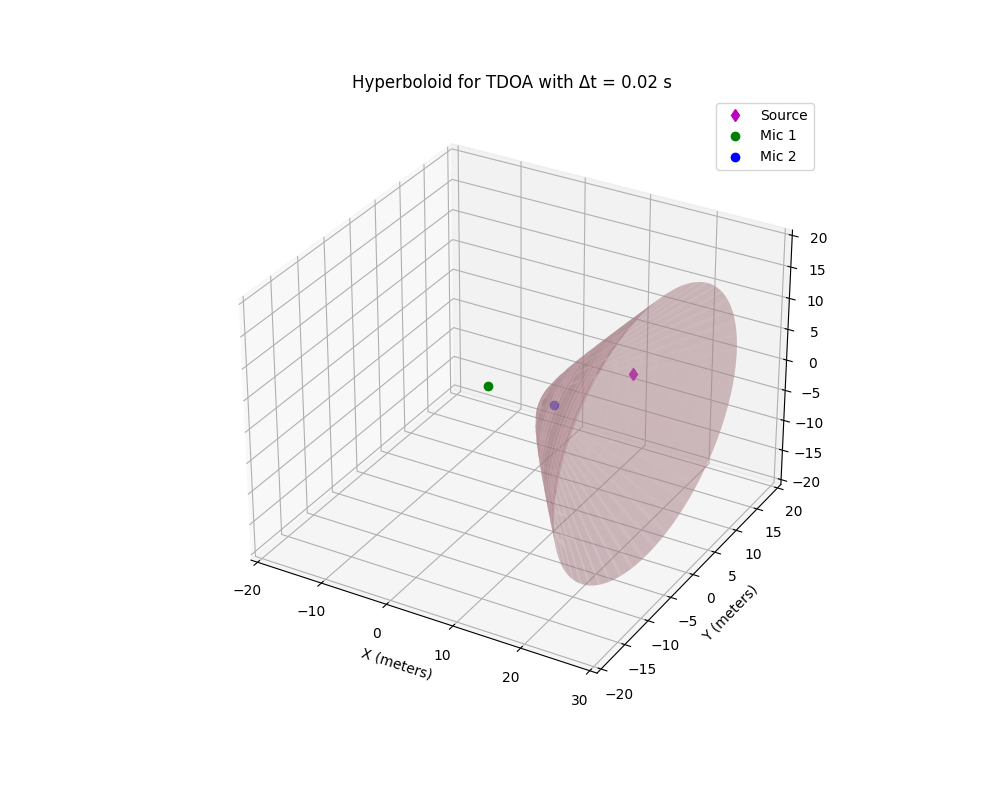

In [8]:
# 3-D interactive plot

# source location
S = np.array([15, 10]) # source position

# Mic positions
M1 = np.array([0, 0]) 
M2 = np.array([10, 0]) 

# Speed of sound/signal (e.g., speed of sound in air ≈ 343 m/s)
c = 343  # meters per second

# Time difference of arrival in seconds
toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2

t_doa = toa_mic1-toa_mic2  # time difference of arrival

# Calculate the distance difference based on the tdoa
d = c * t_doa  # distance difference

# Generate a grid of points
x = np.linspace(-20, 30, 40)
y = np.linspace(-20, 20, 40)
X, Y = np.meshgrid(x, y)

# Calculate the distances to the two mics for each point (X, Y)
D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)

# Calculate the difference in distances
distance_diff = D1 - D2 # this is essentially equal d above

Z_hyp = (d - distance_diff) # this value should be close to zero and is the contour line (hyperbola) we want to plot.

# # Plot the hyperbola where the distance difference is equal to the calculated d

fig_cntr, ax_cntr = plt.subplots()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


def update(xs = 15, ys = 10):
    ax.clear()
    
    S = np.array([xs, ys]) # source position

    # Time difference of arrival in seconds
    toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
    toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2
    
    t_doa = toa_mic1-toa_mic2  # time difference of arrival
    
    # Calculate the distance difference based on the tdoa
    d = c * t_doa  # distance difference

    # Calculate the distances to the two mics for each point (X, Y)
    D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
    D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)
    
    # Calculate the difference in distances
    distance_diff = D1 - D2 # this is essentially equal d above
    
    Z_hyp = (d - distance_diff) # this value should be close to zero and is the contour line (hyperbola) we want to plot.
    
    cmap = ax_cntr.contour(X, Y, Z_hyp, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot
    
    
    # Extract contours for z=0
    contour_paths = cmap.collections[0].get_paths()

    # Get x, y points of the contour
    contour_points = []
    for path in contour_paths:
        contour_points.append(path.vertices)
    contour_points = np.vstack(contour_points)  # Combine all contour segments
    
    x_hyperbola, y_hyperbola = contour_points[:, 0], contour_points[:, 1]

    # Generate the surface of revolution by rotating the contour around y-axis
    theta = np.linspace(0, 2 * np.pi, 100)  # Rotation angles
    theta_grid, y_grid = np.meshgrid(theta, y_hyperbola)
    x_grid = np.tile(x_hyperbola, (len(theta), 1)).T
    z_grid = y_grid * np.sin(theta_grid)  # Rotate in z
    y_grid = y_grid * np.cos(theta_grid)  # Rotate in y

    # Update plot parameters
    
    ax.plot_surface(x_grid, y_grid, z_grid, color="pink", alpha=0.3, edgecolor='none')
    ax.plot(xs, ys, 'md', label="Source")
    ax.set_title(f'Hyperboloid for TDOA with Δt = {np.round(t_doa,decimals=4)} s')
    ax.plot(M1[0], M1[1], 'go', label="Mic 1")
    ax.plot(M2[0], M2[1], 'bo', label="Mic 2")
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_xlim([-20, 30])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-20, 20])
    ax.legend()
    ax.grid(True)

print('Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)')
interact(update, xs = (-20,30,1), ys = (-20,20,1)); 

plt.close(fig_cntr)



Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)


interactive(children=(IntSlider(value=15, description='xs', max=20, min=-20), IntSlider(value=10, description=…

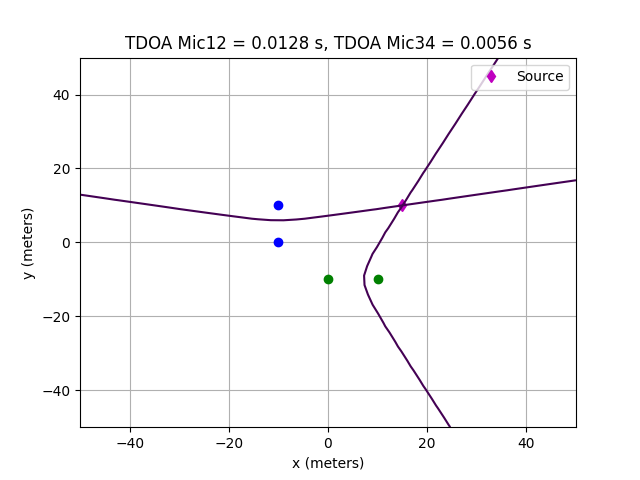

In [9]:
# With two microphone pairs - only using each microphone pair (not all TDOAs)

# source location
S = np.array([15, 10]) # source position

# Mic positions
M1 = np.array([0, -10]) 
M2 = np.array([10, -10]) 

M3 = np.array([-10, 0]) 
M4 = np.array([-10, 10]) 

# Speed of sound/signal (e.g., speed of sound in air ≈ 343 m/s)
c = 343  # meters per second

# Time difference of arrival in seconds
toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2

t_doa = toa_mic1-toa_mic2  # time difference of arrival

# Calculate the distance difference based on the tdoa
d = c * t_doa  # distance difference

# Generate a grid of points
x = np.linspace(-50, 50, 40)
y = np.linspace(-50, 50, 40)
X, Y = np.meshgrid(x, y)

# Calculate the distances to the two mics for each point (X, Y)
D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)

# Calculate the difference in distances
distance_diff = D1 - D2 # this is essentially equal d above

Z_hyp = (d - distance_diff) # this value should be close to zero and is the contour line (hyperbola) we want to plot.

# # Plot the hyperbola where the distance difference is equal to the calculated d

fig, ax = plt.subplots()

ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
# ax.clabel(cmap, inline=True, fontsize=10)
# cb = plt.colorbar(cmap,ax=[ax])





def update(xs = 15, ys = 10):
    ax.clear()
    
    S = np.array([xs, ys]) # source position

    # Time difference of arrival in seconds
    toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
    toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2

    toa_mic3 = np.linalg.norm(S-M3)/c # time of arrival from source to mic3
    toa_mic4 = np.linalg.norm(S-M4)/c # time of arrival from source to mic4
    
    t_doa = toa_mic1-toa_mic2  # time difference of arrival
    t_doa34 = toa_mic3-toa_mic4
    
    # Calculate the distance difference based on the tdoa
    d = c * t_doa  # distance difference
    d34 = c * t_doa34

    # Calculate the distances to the two mics for each point (X, Y)
    D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
    D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)

    D3 = np.sqrt((X - M3[0])**2 + (Y - M3[1])**2)
    D4 = np.sqrt((X - M4[0])**2 + (Y - M4[1])**2)
    
    # Calculate the difference in distances
    distance_diff = D1 - D2 # this is essentially equal d above
    distance_diff34 = D3 - D4
    
    Z_hyp = (d - distance_diff) # this value should be close to zero and is the contour line (hyperbola) we want to plot.
    Z_hyp34 = (d34 - distance_diff34)
    
    ax.plot(xs, ys, 'md', label="Source")
    ax.set_title(f'TDOA Mic12 = {np.round(t_doa,decimals=4)} s, TDOA Mic34 = {np.round(t_doa34,decimals=4)} s')
    ax.plot(M1[0], M1[1], 'go')
    ax.plot(M2[0], M2[1], 'go')
    ax.plot(M3[0], M3[1], 'bo')
    ax.plot(M4[0], M4[1], 'bo')
    ax.set_xlabel('x (meters)')
    ax.set_ylabel('y (meters)')
    ax.legend()
    ax.grid(True)
    
    cmap = ax.contour(X, Y, Z_hyp, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot
    cmap34 = ax.contour(X, Y, Z_hyp34, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot


print('Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)')
interact(update, xs = (-20,20,1), ys = (-20,20,1)); 




Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)


interactive(children=(IntSlider(value=15, description='xs', max=20, min=-20), IntSlider(value=10, description=…

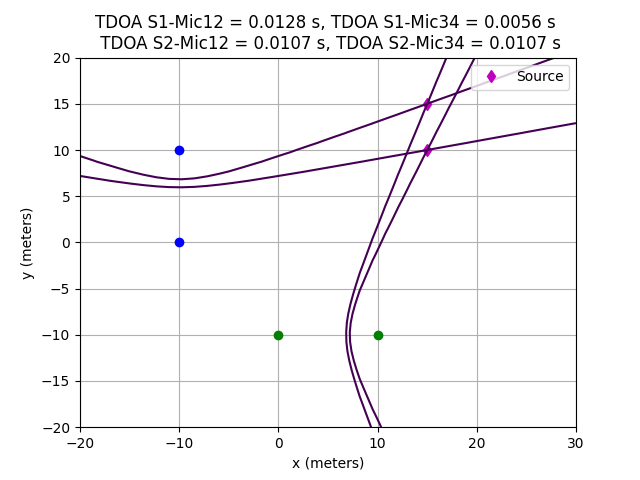

In [100]:
# With two microphone pairs and two sources

# source location
S = np.array([15, 10]) # source position

# Mic positions
M1 = np.array([0, -10]) 
M2 = np.array([10, -10]) 

M3 = np.array([-10, 0]) 
M4 = np.array([-10, 10]) 

# Speed of sound/signal (e.g., speed of sound in air ≈ 343 m/s)
c = 343  # meters per second

# Time difference of arrival in seconds
toa_mic1 = np.linalg.norm(S-M1)/c # time of arrival from source to mic1
toa_mic2 = np.linalg.norm(S-M2)/c # time of arrival from source to mic2

t_doa = toa_mic1-toa_mic2  # time difference of arrival

# Calculate the distance difference based on the tdoa
d = c * t_doa  # distance difference

# Generate a grid of points
x = np.linspace(-20, 30, 40)
y = np.linspace(-20, 20, 40)
X, Y = np.meshgrid(x, y)


# Plots
fig, ax = plt.subplots()
ax.set_xlim([-20, 30])
ax.set_ylim([-20, 20])


def update(xs = 15, ys = 10, xs2= 15, ys2=15):
    ax.clear()
    
    S1 = np.array([xs, ys]) # source position
    S2 = np.array([xs2, ys2]) # 2nd source position

    # Time difference of arrival in seconds - from S1
    toa_S1_M1 = np.linalg.norm(S1-M1)/c # time of arrival from S1 to mic1
    toa_S1_M2 = np.linalg.norm(S1-M2)/c # time of arrival from S1 to mic2
    toa_S1_M3 = np.linalg.norm(S1-M3)/c # time of arrival from S1 to mic3
    toa_S1_M4 = np.linalg.norm(S1-M4)/c # time of arrival from S1 to mic4
    
    t_doa_S1_M12 = toa_S1_M1-toa_S1_M2  # time difference of arrival
    t_doa_S1_M34 = toa_S1_M3-toa_S1_M4

    d_S1_M12 = c * t_doa_S1_M12      # Calculate the distance difference based on the tdoa
    d_S1_M34 = c * t_doa_S1_M34

    
    # Time difference of arrival in seconds - from S2
    toa_S2_M1 = np.linalg.norm(S2-M1)/c # time of arrival from S2 to mic1
    toa_S2_M2 = np.linalg.norm(S2-M2)/c # time of arrival from S2 to mic2
    toa_S2_M3 = np.linalg.norm(S2-M3)/c # time of arrival from S2 to mic3
    toa_S2_M4 = np.linalg.norm(S2-M4)/c # time of arrival from S2 to mic4

    t_doa_S2_M12 = toa_S2_M1-toa_S2_M2  # time difference of arrival
    t_doa_S2_M34 = toa_S2_M3-toa_S2_M4

    d_S2_M12 = c * t_doa_S2_M12      # Calculate the distance difference based on the tdoa
    d_S2_M34 = c * t_doa_S2_M34
    
    
    # Calculate the distances to the two mics for each point (X, Y)
    D1 = np.sqrt((X - M1[0])**2 + (Y - M1[1])**2)
    D2 = np.sqrt((X - M2[0])**2 + (Y - M2[1])**2)

    D3 = np.sqrt((X - M3[0])**2 + (Y - M3[1])**2)
    D4 = np.sqrt((X - M4[0])**2 + (Y - M4[1])**2)
    
    
    # Calculate the difference in distances
    D_12 = D1 - D2 
    D_34 = D3 - D4

    Z_hyp_S1_M12 = d_S1_M12 - D_12
    Z_hyp_S1_M34 = d_S1_M34 - D_34
    Z_hyp_S2_M12 = d_S2_M12 - D_12
    Z_hyp_S2_M34 = d_S2_M34 - D_34
        
    ax.plot([xs,xs2], [ys,ys2], 'md', label="Source")
    ax.set_title(f'TDOA S1-Mic12 = {np.round(t_doa_S1_M12,decimals=4)} s, TDOA S1-Mic34 = {np.round(t_doa_S1_M34,decimals=4)} s \n TDOA S2-Mic12 = {np.round(t_doa_S2_M12,decimals=4)} s, TDOA S2-Mic34 = {np.round(t_doa_S2_M34,decimals=4)} s')
    ax.plot(M1[0], M1[1], 'go')
    ax.plot(M2[0], M2[1], 'go')
    ax.plot(M3[0], M3[1], 'bo')
    ax.plot(M4[0], M4[1], 'bo')
    ax.set_xlabel('x (meters)')
    ax.set_ylabel('y (meters)')
    ax.legend()
    ax.grid(True)
    
    cmap_S1_M12 = ax.contour(X, Y, Z_hyp_S1_M12, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot
    cmap_S1_M34 = ax.contour(X, Y, Z_hyp_S1_M34, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot
    cmap_S2_M12 = ax.contour(X, Y, Z_hyp_S2_M12, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot
    cmap_S2_M34 = ax.contour(X, Y, Z_hyp_S2_M34, levels=[0]) # plot the level == 0, putting the 0 in brackets tells python plot that value, otherwise it tells python how many levels to plot

print('Move the slider to see how the hyperbola changes as the source position changes (and hence TDOA changes)')
interact(update, xs = (-20,20,1), ys = (-20,20,1), xs2 = (-20,20,1), ys2 = (-20,20,1)); 




### References

In this notebook, we have only scratched the surface on methods for sound source localization. We looked at 3 concepts - the cross-correlation, direction of arrival (DOA), and hyperbolic localization. Sound source localization can be done in two stages, i.e., first using the cross-correlation to get time-delay estimates and then apply DOA/TDOA strategies, or alternatively can be done in one stage, where the time delays are not explicitly estimated, but their information is used in some other way, e.g., to steer a beamformer to a particular direction and estimate the amount of energy from the steered location. We will save the analysis of these methods for a later notebook, but here are a few references which are good starting points to look further into sound source localization.

1. Rhinehart, Tessa A., Lauren M. Chronister, Trieste Devlin, and Justin Kitzes. "Acoustic localization of terrestrial wildlife: Current practices and future opportunities." Ecology and Evolution 10, no. 13 (2020): 6794-6818. (https://doi.org/10.1002/ece3.6216)

2. Spiesberger, John L., and Kurt M. Fristrup. "Passive localization of calling animals and sensing of their acoustic environment using acoustic tomography." The american naturalist 135, no. 1 (1990): 107-153. (https://www.journals.uchicago.edu/doi/abs/10.1086/285035)

3. Here's a reference with a mathematical proof that the TDOA equation results in a hyperbola: https://people.richland.edu/james/lecture/m116/conics/hypdef.html
